In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook  import tqdm, trange
from tqdm import tqdm
from scipy import stats
import matplotlib as mpl
import ast
from sklearn import cluster

# Import data

In [2]:
news = pd.read_csv('../thematic_clustering/lda_128_large/news_thematic_clustering_large_final.csv', index_col=0)

In [3]:
news.head(2)

,NewsID,Category,SubCategory,Title,Abstract,URL,Title_entities,Abstract_entities,Source,Text,Embedding,Date,Category_id,cluster_hdbscan,proba,tokens
0,93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",nytimes.com,zolote ukraine lt ivan molchanets peek parapet...,"[5.403303475759458e-06, 0.23899737000465393, 5...",2019-10-25,0,3,1.000000,"['zolote', 'ukraine', 'lt', 'ivan', 'molchanet..."
1,40259,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,https://assets.msn.com/labs/mind/AAJ43pw.html,"[{""Label"": ""Chile"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Santiago"", ""Type"": ""G"", ""WikidataI...",cnn.com,people die supermarket fire angry protest chil...,"[3.7435991544043645e-05, 3.7435991544043645e-0...",2019-10-20,0,6,0.954876,"['people', 'die', 'supermarket', 'fire', 'angr..."


In [112]:
behaviors =  pd.read_csv('../data_mind_large_news/ratings_10k.csv')

In [113]:
behaviors.head()

,UserID,NewsID,Score,Time
0,504290,106909,0,2019-11-09 00:00:44
1,504290,101469,0,2019-11-09 00:00:44
2,504290,95605,0,2019-11-09 00:00:44
3,504290,96061,0,2019-11-09 00:00:44
4,504290,130031,0,2019-11-09 00:00:44


In [114]:
behaviors.shape

(2052051, 4)

In [115]:
behaviors = behaviors.merge(news[['NewsID','SubCategory','Title','cluster_hdbscan','proba']], on='NewsID')

In [116]:
behaviors.head()

,UserID,NewsID,Score,Time,SubCategory,Title,cluster_hdbscan,proba
0,504290,106909,0,2019-11-09 00:00:44,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",10,0.875347
1,219624,106909,0,2019-11-09 03:42:46,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",10,0.875347
2,10420,106909,0,2019-11-09 04:38:36,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",10,0.875347
3,511303,106909,0,2019-11-09 05:32:00,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",10,0.875347
4,184564,106909,0,2019-11-09 05:54:33,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",10,0.875347


# Study of users' behavior

In [117]:
# Get the count of each unique 'cluster' value for each unique 'userID' for interactions
user_cluster_counts_r1 = behaviors[behaviors['Score']==1].groupby('UserID')['cluster_hdbscan'].value_counts()
user_cluster_counts_r1 = pd.DataFrame(user_cluster_counts_r1).rename(columns={'cluster_hdbscan':'count'})
user_cluster_counts_r1 = user_cluster_counts_r1.reset_index(drop=False)

In [118]:
user_cluster_counts_r1

,UserID,cluster_hdbscan,count
0,1,8,21
1,1,5,8
2,1,-1,6
3,1,4,2
4,1,3,1
...,...,...,...
84442,711162,3,2
84443,711162,6,2
84444,711162,10,2
84445,711162,5,1


# Sub-profiles definition

In [119]:
#Add +1 on cluster_hdbscan to not have -1 for outliers
behaviors['cluster_hdbscan'] = behaviors['cluster_hdbscan']+1

In [120]:
#News that are identified as outliers are not set apart, but as a category as a whole (general category)
behaviors['proba'] = behaviors['proba'].replace(0, 1)

### Compute likelihood of the interest of user u in each category

In [121]:
categories = behaviors['cluster_hdbscan'].unique().tolist()
categories.sort()

In [122]:
list_users = behaviors['UserID'].unique().tolist()

In [125]:
categories_distribution = pd.DataFrame(columns=categories, index=list_users)

In [126]:
def likelihood_categories(behaviors_df, list_categories, list_users):
    categories_distribution = pd.DataFrame(columns=list_categories, index=list_users)
    for u in tqdm(list_users):
        user_df = behaviors_df[(behaviors_df['UserID']==u) & (behaviors_df['Score']==1)]
        denominator = sum(user_df['Score']*user_df['proba'])
        for c in list_categories:
            user_df_cat = user_df[user_df['cluster_hdbscan']==c]
            numerator = sum(user_df_cat['Score']*user_df_cat['proba'])
            categories_distribution.loc[u,c] = numerator/denominator
    return categories_distribution

In [127]:
categories_distribution = likelihood_categories(behaviors, categories, list_users)

100%|██████████| 10000/10000 [02:57<00:00, 56.28it/s]


In [128]:
categories_distribution.index = list_users

In [129]:
categories_distribution

,0,1,2,3,4,5,6,7,8,9,10,11,12
504290,0.371146,0.0,0.0,0.02651,0.073689,0.0,0.121311,0.362576,0.0,0.018257,0.0,0.0,0.02651
219624,0.338185,0.024156,0.0,0.022688,0.048312,0.0,0.151739,0.286625,0.0,0.058824,0.048312,0.021158,0.0
10420,0.338911,0.0,0.0,0.0,0.217548,0.021182,0.037526,0.042364,0.021182,0.185595,0.081045,0.054647,0.0
511303,0.152604,0.0,0.0,0.021801,0.078364,0.037012,0.057583,0.238153,0.0,0.354836,0.020975,0.038672,0.0
184564,0.276437,0.0,0.0,0.024599,0.07994,0.0,0.089455,0.15472,0.027644,0.273652,0.027644,0.045911,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292183,0.282792,0.0,0.0,0.0,0.0,0.0,0.054277,0.087007,0.0,0.39324,0.0,0.182684,0.0
646273,0.476536,0.0,0.0,0.0,0.029783,0.0,0.11069,0.174696,0.029783,0.128191,0.0,0.050321,0.0
324828,0.17491,0.0,0.0,0.0,0.260469,0.047388,0.012758,0.048996,0.0,0.34971,0.0,0.105769,0.0
108536,0.378734,0.0,0.022237,0.0,0.313166,0.0,0.075075,0.094684,0.0,0.055484,0.030366,0.030254,0.0


In [130]:
categories_distribution.to_csv('categories_distribution_subprofiles_10k.csv')

## Define sub-profiles

In [131]:
behaviors.head(10)

,UserID,NewsID,Score,Time,SubCategory,Title,cluster_hdbscan,proba
0,504290,106909,0,2019-11-09 00:00:44,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
1,219624,106909,0,2019-11-09 03:42:46,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
2,10420,106909,0,2019-11-09 04:38:36,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
3,511303,106909,0,2019-11-09 05:32:00,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
4,184564,106909,0,2019-11-09 05:54:33,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
5,467213,106909,0,2019-11-09 06:14:52,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
6,33560,106909,0,2019-11-09 06:16:15,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
7,160605,106909,0,2019-11-09 06:31:48,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
8,411546,106909,0,2019-11-09 06:42:08,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347
9,326863,106909,0,2019-11-09 06:44:58,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347


In [132]:
def define_subprofiles(behaviors_df, distribution_df, threshold=0):
    for i in tqdm(range(len(behaviors_df))):
        user = behaviors_df.loc[i, 'UserID']
        category = behaviors_df.loc[i, 'cluster_hdbscan']
        if distribution_df.loc[user, category] >= threshold:
            behaviors_df.loc[i,'subprofile'] = str(user)+'-'+str(category)
    subprofiles = behaviors_df[~behaviors_df['subprofile'].isna()]
    return behaviors_df

In [133]:
subprofiles = define_subprofiles(behaviors, categories_distribution)

100%|██████████| 2052051/2052051 [06:21<00:00, 5385.87it/s]


In [136]:
subprofiles.head()

,UserID,NewsID,Score,Time,SubCategory,Title,cluster_hdbscan,proba,subprofile
0,504290,106909,0,2019-11-09 00:00:44,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,504290-11
1,219624,106909,0,2019-11-09 03:42:46,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,219624-11
2,10420,106909,0,2019-11-09 04:38:36,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,10420-11
3,511303,106909,0,2019-11-09 05:32:00,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,511303-11
4,184564,106909,0,2019-11-09 05:54:33,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,184564-11


In [137]:
subprofiles = subprofiles[~subprofiles['subprofile'].isna()]

In [138]:
print('Number of subprofiles:', subprofiles['subprofile'].nunique())

Number of subprofiles: 112707


In [139]:
subprofiles.to_csv('behaviors_sub_profiles_10k.csv')

In [140]:
ratings_sub_profiles = subprofiles[['subprofile','NewsID','Score']]

In [141]:
ratings_sub_profiles.to_csv('ratings_sub_profiles_10k.csv',index=False)

# Sub-profiles analysis

In [107]:
#behaviors = pd.read_csv('behaviors_sub_profiles.csv', index_col=0)

In [142]:
behaviors = behaviors.reset_index(drop=True)

In [143]:
behaviors.head()

,UserID,NewsID,Score,Time,SubCategory,Title,cluster_hdbscan,proba,subprofile
0,504290,106909,0,2019-11-09 00:00:44,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,504290-11
1,219624,106909,0,2019-11-09 03:42:46,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,219624-11
2,10420,106909,0,2019-11-09 04:38:36,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,10420-11
3,511303,106909,0,2019-11-09 05:32:00,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,511303-11
4,184564,106909,0,2019-11-09 05:54:33,elections-2020-us,"As Bloomberg's New York Prospered, Inequality ...",11,0.875347,184564-11


In [144]:
behaviors['subprofile'].nunique()

112707

In [145]:
infos_users = pd.DataFrame(columns=['nb_sub_profiles','nb_clusters','total_interactions'])
for u in tqdm(list_users):
    nb_sub_profiles = behaviors[behaviors['UserID']==u]['subprofile'].nunique()
    nb_clusters = behaviors[behaviors['UserID']==u]['cluster_hdbscan'].nunique()
    total_interactions = len(behaviors[(behaviors['UserID']==u) & (behaviors['Score']==1)])
    new_row = {'nb_sub_profiles':nb_sub_profiles, 'nb_clusters':nb_clusters, 'total_interactions':total_interactions}
    infos_users.loc[u] = new_row

100%|██████████| 10000/10000 [02:48<00:00, 59.47it/s]


In [146]:
infos_users

,nb_sub_profiles,nb_clusters,total_interactions
504290,11,11,41
219624,11,11,44
10420,13,13,50
511303,11,11,49
184564,11,11,39
...,...,...,...
292183,12,12,35
646273,10,10,36
324828,11,11,45
108536,11,11,34


In [147]:
infos_users['nb_sub_profiles'].value_counts()

12    3277
11    2883
10    1557
13    1454
9      626
8      154
7       39
6        9
5        1
Name: nb_sub_profiles, dtype: int64

In [148]:
infos_users['nb_sub_profiles'].describe()

count    10000.000000
mean        11.270700
std          1.212175
min          5.000000
25%         11.000000
50%         11.000000
75%         12.000000
max         13.000000
Name: nb_sub_profiles, dtype: float64

<AxesSubplot:xlabel='nb_sub_profiles', ylabel='Count'>

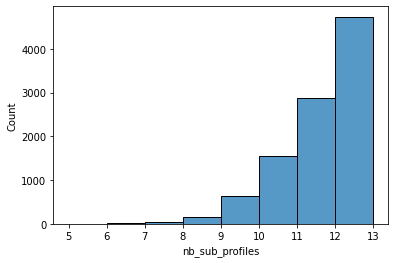

In [149]:
sns.histplot(data=infos_users['nb_sub_profiles'], bins=8)

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


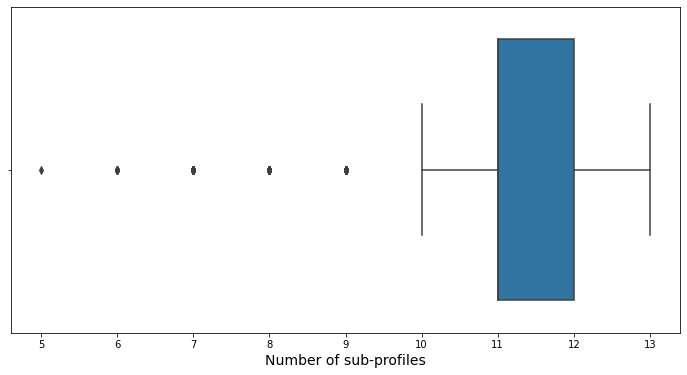

In [150]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(infos_users['nb_sub_profiles'])
ax.set_xlabel('Number of sub-profiles', fontsize='14')
plt.show()